# Import libraries & parse arguments

In [1]:
import os
import torch
import random
import librosa
import numpy as np
import IPython.display

from utils.audio import Audio
from utils.hparams import HParam

In [25]:
%matplotlib inline

from mir_eval.separation import bss_eval_sources
import matplotlib
import matplotlib.pyplot as plt

In [26]:
from utils.hparams import HParam
from datasets.dataloader import create_dataloader

In [27]:
import torch
import torch.nn as nn

from model.model import VoiceFilter
from model.embedder import SpeechEmbedder

In [3]:
hp = HParam("config.yaml")

/root/voicefilter/utils/hparams.py:18: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for doc in docs:


In [28]:
from datasets.GGSpeakerIDDataset import create_dataset
dt = create_dataset(hp, "test")

In [ ]:
dt[307]

# Prepare

Create testloader and get first sample

In [6]:
testloader = create_dataloader(hp, "generate", dataset_detail=["zalo-train", "zalo-test"], scheme="test")
testloader_gg = create_dataloader(hp, "gg", dataset_detail="test", scheme="test")
it = iter(testloader)
it_gg = iter(testloader_gg)

Audio is an abstract class that help simplify many operation on a single audio file like convert to mel, waveform to mel or mel to waveform,...

In [14]:
audio = Audio(hp)

Load pretrained

In [8]:
device = "cpu"

embedder_pt = torch.load("embedder.pt", device)
embedder = SpeechEmbedder(hp)
embedder.load_state_dict(embedder_pt)
embedder.eval()

# Power-law compressed loss
model = VoiceFilter(hp)
checkpoint = torch.load("chkpt/powlaw_loss/chkpt_168000.pt", device)
model.load_state_dict(checkpoint['model'])
model.eval()


# First try (MSE loss)
model_0 = VoiceFilter(hp)
checkpoint = torch.load("chkpt/new_dataloader/chkpt_108000.pt", device)
model_0.load_state_dict(checkpoint['model'])
model_0.eval()

# MSE ver 48k (ms.Tam)
model_t = VoiceFilter(hp)
checkpoint = torch.load("chkpt/mstam_mse/chkpt_48000.pt", device)
model_t.load_state_dict(checkpoint['model'])
model_t.eval()

pass

Plot spectrogram function

In [9]:
def plot_spectrogram(spectrogram, title=None, range=None):
    fig, axs = plt.subplots(figsize=(12, 3))
    im = axs.imshow(spectrogram, aspect='auto', origin='lower')
    if range:
        im.set_clim(vmin=range[0], vmax=range[1])
        
    axs.set_xlabel('Frames')
    axs.set_ylabel('Channels')
    if title:
        axs.set_title(title)
    fig.colorbar(im, ax=axs)

# Main

In [10]:
class PowerLawCompLoss(nn.Module):
  
    def __init__(self, 
                   power: float = 0.3,
                   complex_loss_ratio: float = 0.113,
                   reduction: str = 'mean') -> None:
        super(PowerLawCompLoss, self).__init__()
        self.power = power
        self.alpha = complex_loss_ratio
        self.l2_norm = nn.MSELoss(reduction=reduction)

    def forward(self, mask, input, target):    
        input = mask*torch.pow(input, self.power)
        target = torch.pow(target, self.power)
        magnitude_loss = self.l2_norm(input.abs(), target.abs())
        # MSE doesn't support complex number yet
        complex_loss = ((input - target).abs()**2).mean()
        return magnitude_loss + self.alpha * complex_loss

Inference function for power-law compressed model

In [11]:
def powerlaw_inference(model, batch):
    criterion = PowerLawCompLoss()
    _, _, _, dvec_mel, target_wav, mixed_wav, target_mag, _, mixed_mag, _, target_stft, mixed_stft = batch
    
    dvec = embedder(dvec_mel)
    dvec = dvec.unsqueeze(0)
    target_stft = target_stft.unsqueeze(0)
    mixed_stft = mixed_stft.unsqueeze(0)
    

    est_mask = model(torch.pow(mixed_stft.abs(), 0.3), dvec)
    print("Loss: ", criterion(est_mask, mixed_stft, target_stft).item())
    est_mask = torch.pow(est_mask, 10/3)
    est_stft = mixed_stft * est_mask

    mixed_stft = mixed_stft[0].numpy()
    target_stft = target_stft[0].numpy()
    est_stft = est_stft[0].detach().numpy()
    est_wav = audio._istft(est_stft.T, length=mixed_wav.shape[0])
    est_mask = est_mask[0].detach().numpy()

    est_mag, _ = audio.stft2spec(est_stft.T)

    print("SDR: ", bss_eval_sources(target_wav, est_wav, False)[0][0])

    plot_spectrogram(mixed_mag.T, "Mixed spectrogram (db normed)", (0,1))
    plot_spectrogram(target_mag.T, "Target spectrogram (db normed)", (0,1))
    plot_spectrogram(est_mag.T, "Masked spectrogram (db normed)", (0,1))

    plot_spectrogram(np.abs(mixed_stft**0.3).T, "Mixed spectrogram (compressed)")
    plot_spectrogram(np.abs(target_stft**0.3).T, "Target spectrogram (compressed)")
    plot_spectrogram(np.abs(est_stft**0.3).T, "Masked spectrogram (compressed)")

    plot_spectrogram(est_mask.T, "Mask", (0,1))
    plot_spectrogram(np.abs(target_stft.T)/np.abs(mixed_stft.T), "Expected Mask (computed)", (0,1))
    plot_spectrogram(np.square(target_mag-est_mag).T, "Pred diff", (0,1))
    plot_spectrogram(np.square(target_mag-mixed_mag).T, "Ground diff", (0,1))

    return est_wav, est_mag.T, est_mask.T

In [28]:
def mse_inference(model, batch):
    criterion = nn.MSELoss()
    _, _, _, dvec_mel, target_wav, mixed_wav, target_mag, _, mixed_mag, mixed_phase, target_stft, mixed_stft = batch
    
    dvec = embedder(dvec_mel)
    dvec = dvec.unsqueeze(0)
    mixed_mag = mixed_mag.unsqueeze(0)
    target_mag = target_mag.unsqueeze(0)
    
    est_mask = model(mixed_mag, dvec)
    est_mag = mixed_mag * est_mask
    
    print("Loss: ", criterion(target_mag, est_mag).item())

    mixed_mag = mixed_mag[0].numpy()
    target_mag = target_mag[0].numpy()
    est_mag = est_mag[0].detach().numpy()
    mixed_phase = mixed_phase.numpy()
    est_wav = audio.spec2wav(est_mag, mixed_phase, length=mixed_wav.shape[0])
    est_mag, _ = audio.wav2spec(est_wav)
    est_mask = est_mask[0].detach().numpy()

    print("SDR before: ", bss_eval_sources(target_wav, mixed_wav, False)[0][0])
    print("SDR after: ", bss_eval_sources(target_wav, est_wav, False)[0][0])

    plot_spectrogram(mixed_mag.T, "Mixed spectrogram (db normed)", (0,1))
    plot_spectrogram(target_mag.T, "Target spectrogram (db normed)", (0,1))
    plot_spectrogram(est_mag.T, "Masked spectrogram (db normed)", (0,1))
    plot_spectrogram(np.abs(audio.stft(est_wav))/np.abs(mixed_stft.T), "Mask (computed)", (0,1))
    plot_spectrogram(est_mask.T, "Mask (on db normed)", (0,1))
    plot_spectrogram(np.square(target_mag-est_mag).T, "Pred diff", (0,1))
    plot_spectrogram(np.square(target_mag-mixed_mag).T, "Ground diff", (0,1))

    return est_wav, est_mag.T, est_mask.T

In [46]:
batch = next(it)
batch = batch[0]

In [47]:
s1_dvec, s1_target, s2, _, target_wav, mixed_wav, *rest = batch

In [48]:
print(s1_dvec)
print(s1_target)
print(s2)

datasets/ZaloAI2020/dataset/49/49-F-26/16k_49-13.wav
datasets/ZaloAI2020/dataset/49/49-F-26/16k_49-7.wav
datasets/ZaloAI2020/dataset/455/455-F-24/16k_455-31.wav


In [49]:
IPython.display.Audio(s1_target)

In [50]:
IPython.display.Audio(s1_dvec)

In [51]:
IPython.display.Audio(mixed_wav, rate=16000)

In [52]:
IPython.display.Audio(target_wav, rate=16000)

Loss:  0.03372914716601372
SDR before:  -9.848072303415762
SDR after:  -15.131811332804537


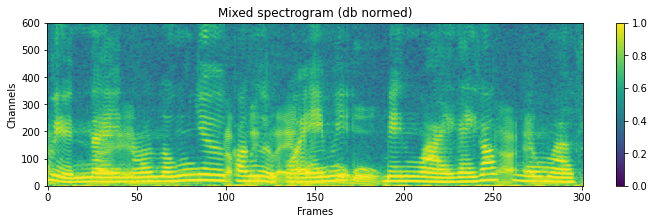

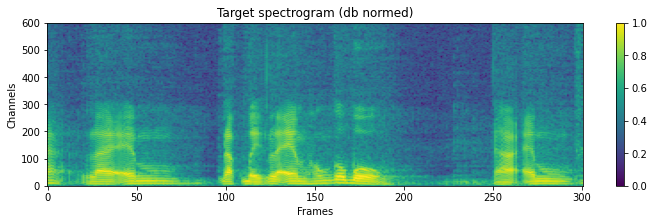

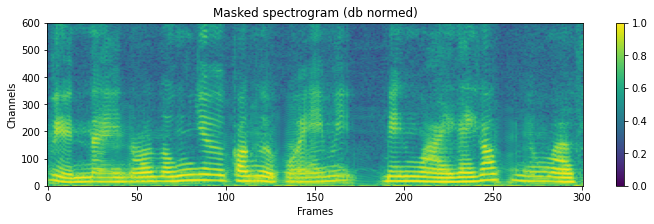

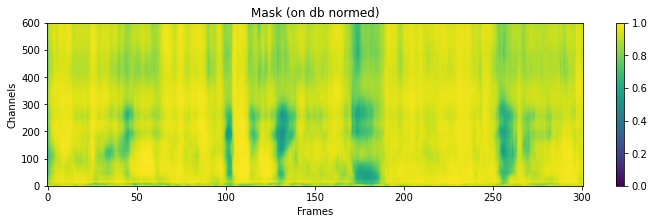

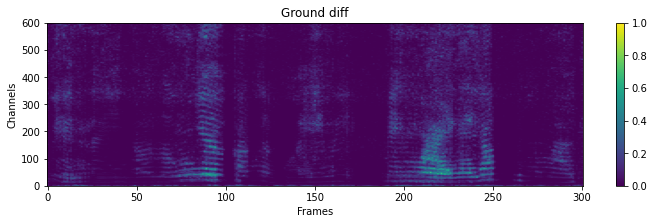

In [53]:
est_wav, _, _ = mse_inference(model_0, batch)

In [54]:
IPython.display.Audio(est_wav, rate=16000)

Loss:  0.027214309200644493
SDR before:  -9.848072303415762
SDR after:  -13.625705962589196


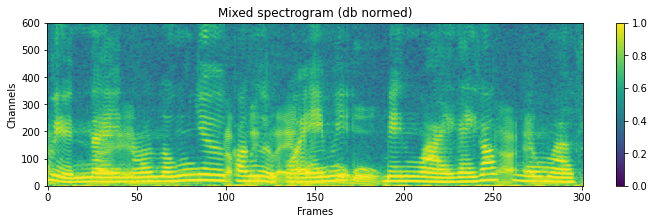

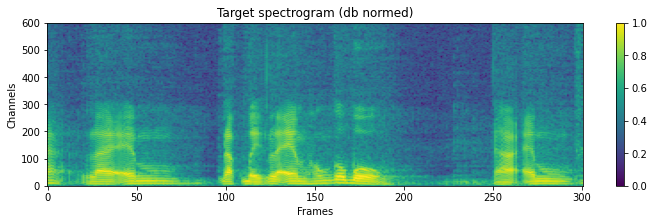

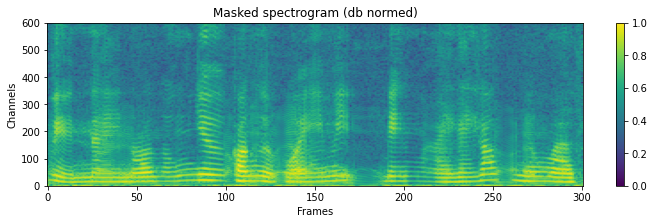

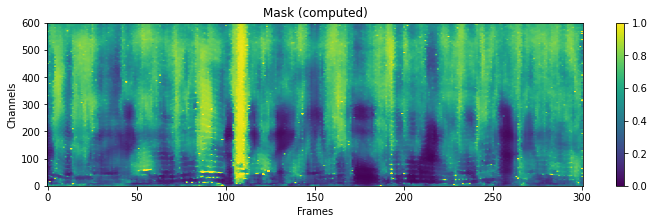

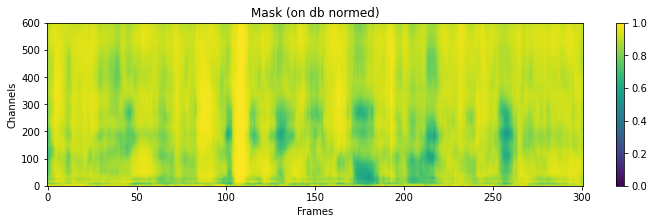

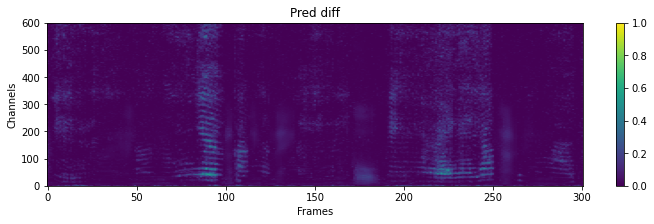

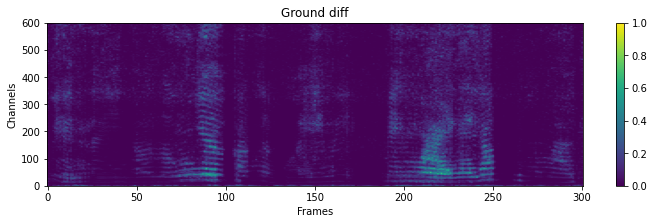

In [55]:
est_wav, _, _ = mse_inference(model_t, batch)

In [56]:
IPython.display.Audio(est_wav, rate=16000)

Loss:  0.1719791144132614
SDR:  -15.585111044524877


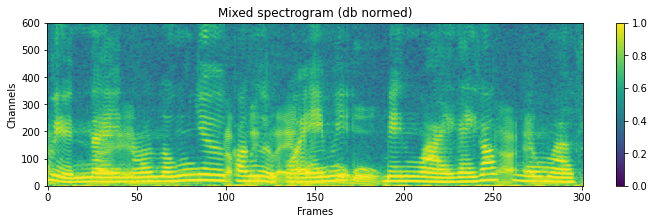

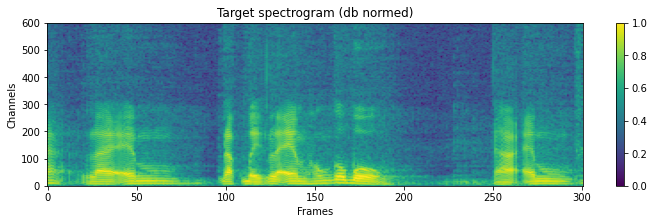

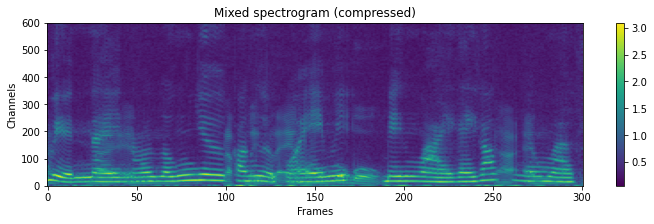

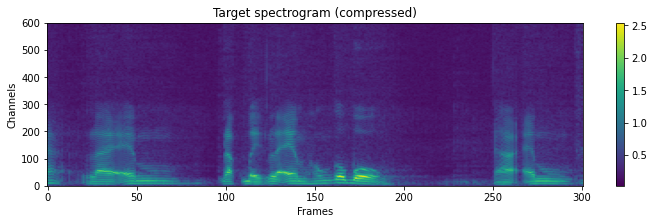

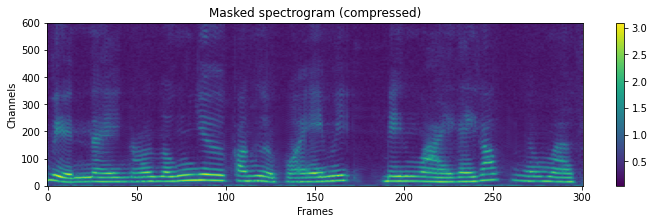

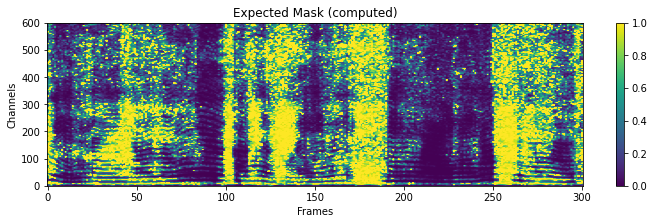

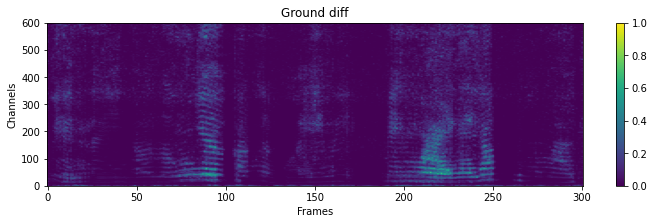

In [57]:
est_wav, _, _ = powerlaw_inference(model, batch)

In [58]:
IPython.display.Audio(est_wav, rate=16000)